### laptime analysis

answer the questions:

1. any trend in the lap time over laps observable?


# Imports

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# to use only one GPU.
# use this on r-001
# otherwise comment
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"


## Load Data

In [2]:
import os
os.getcwd()


'/scratch/hpda/indycar/predictor/notebook/DataAnalysis'

In [3]:
#
# parameters
#
#year = '2017'
year = '2018'
#event = 'Toronto'
event = 'Indy500'

inputfile = '../C_'+ event +'-' + year + '-final.csv'
outputprefix = year +'-' + event + '-'
dataset = pd.read_csv(inputfile)
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18500 entries, 0 to 18499
Data columns (total 21 columns):
rank                    18500 non-null int64
car_number              18500 non-null int64
unique_id               18500 non-null object
completed_laps          18500 non-null int64
elapsed_time            18500 non-null float64
last_laptime            18500 non-null float64
lap_status              18500 non-null object
best_laptime            18500 non-null float64
best_lap                18500 non-null object
time_behind_leader      18500 non-null float64
laps_behind_leade       18500 non-null object
time_behind_prec        18500 non-null float64
laps_behind_prec        18500 non-null object
overall_rank            18500 non-null object
overall_best_laptime    18500 non-null float64
current_status          18500 non-null object
track_status            18500 non-null object
pit_stop_count          18500 non-null object
last_pitted_lap         18500 non-null object
start_position

In [4]:
# make indy car completed_laps dataset
# car_number, completed_laps, rank, elapsed_time, rank_diff, elapsed_time_diff 
def make_cl_data(dataset):

    # pick up data with valid rank
    rankdata = dataset.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')

    # resort by car_number, lap
    uni_ds = rankdata.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True)    
    uni_ds = uni_ds.drop(["unique_id", "best_lap", "current_status", "track_status", "lap_status",
                      "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
                      "last_pitted_lap","start_position","laps_led"], axis=1)
    
    carnumber = set(uni_ds['car_number'])
    print('cars:', carnumber)
    print('#cars=', len(carnumber))
   
    # faster solution , uni_ds already sorted by car_number and lap
    uni_ds['rank_diff'] = uni_ds['rank'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['rank_diff'][mask] = 0
    
    uni_ds['time_diff'] = uni_ds['elapsed_time'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['time_diff'][mask] = 0
    
    df = uni_ds[['car_number','completed_laps','rank','elapsed_time','rank_diff','time_diff']]
    
    return df

def make_lapstatus_data(dataset):
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)
    
    #pick up one of them
    onecar = dataset[dataset['car_number']==completed_car_numbers[0]]
    onecar = onecar.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    return onecar[['completed_laps','track_status']]
    

In [5]:
final_lap = max(dataset.completed_laps)
total_laps = final_lap + 1

# get records for the cars that finish the race
completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
completed_car_count = len(completed_car_numbers)

print('count of completed cars:', completed_car_count)
print('completed cars:', completed_car_numbers)

#make a copy
alldata = dataset.copy()
dataset = dataset[dataset['car_number'].isin(completed_car_numbers)]
rankdata = alldata.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')

count of completed cars: 18
completed cars: [12 20  9 27 28 22 29  1  6 15 66 98  4 88 25 60 64 23]


In [6]:
cldata = make_cl_data(dataset)
#cldata.to_csv(outputprefix + 'completed_laps_diff.csv')

flagdata = make_lapstatus_data(dataset)
#flagdata.to_csv(outputprefix + 'flagstatus.csv')

acldata = make_cl_data(alldata)
#cldata.to_csv(outputprefix + 'all_completed_laps_diff.csv')

cars: {64, 1, 66, 98, 4, 6, 9, 12, 60, 15, 20, 22, 23, 88, 25, 27, 28, 29}
#cars= 18
count of completed cars: 18
completed cars: [12 20  9 27 28 22 29  1  6 15 66 98  4 88 25 60 64 23]
cars: {1, 3, 4, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 59, 60, 64, 66, 88, 98}
#cars= 33


/scratch/hpda/anaconda3/envs/predictor/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/scratch/hpda/anaconda3/envs/predictor/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### overall view of laptime scatter plots



In [100]:
curcarno = 12
car = acldata[acldata['car_number']==curcarno]
print(car['time_diff'].describe())
#car['time_diff'][:total_laps].plot(marker='.')




count    201.000000
mean      53.643840
std       23.085979
min        0.000000
25%       41.181000
50%       41.526500
75%       52.474600
max      117.870100
Name: time_diff, dtype: float64


In [101]:
cols=['completed_laps','rank','car_number','lap_status','track_status',
    'pit_stop_count','current_status','start_position']
colid={key:idx for idx, key in enumerate(cols)}

cardata = rankdata[rankdata['car_number'] == curcarno]

carstatus = [[row[0], row[1],row[2],row[3],row[4],row[5],row[6],row[7]] for row in cardata[
    ['completed_laps','rank','car_number','lap_status','track_status',
    'pit_stop_count','current_status','start_position']].values]

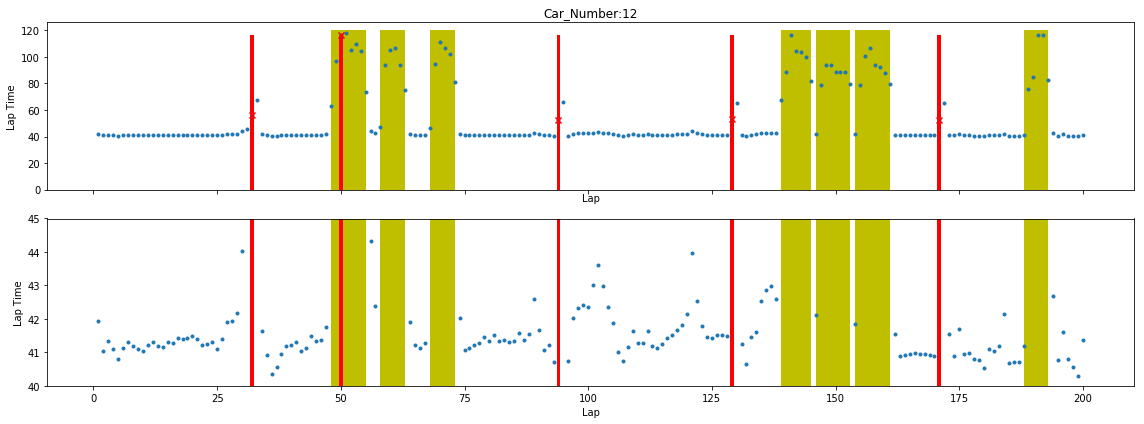

In [102]:
fig, axes = plt.subplots(2,sharex=True,figsize=(16,6))
#fig.set_size_inches(15,8)



x = car['completed_laps'][1:].values
y = car['time_diff'][1:].values



pits=[]
yellowflags=[]
lastflag = 'x'
for row in carstatus:
    lap = int(row[colid['completed_laps']])
    
    if row[colid['lap_status']]=='P':
        pits.append(lap)
        
    if row[colid['track_status']]=='Y':
        if lastflag != 'Y':       
            #start
            yellowflags.append(lap)
    else:
        if lastflag == 'Y':       
            #end
            yellowflags.append(lap)        
    lastflag = row[colid['track_status']]
        
#pit lap
pits = np.array(pits)
#start, end lap
yellowflags = np.array(yellowflags).reshape((-1,2))
        
def draw_laptime(ax):
    #yellow flags
    for yflag in yellowflags:
        ax.bar(yflag[0],120, width = yflag[1] - yflag[0], align='edge', color = 'y', zorder=-100)

    #plt.plot(np.arange(laptime.shape[0]), laptime, marker='.')
    ax.scatter(x, y, marker='.')    

    #pit stops    
    ax.scatter(pits, y[pits-1], marker='x', color='r')
    for pit in pits:
        ax.bar(pit,height = y[pits-1], width = .8, align='center', color = 'r', zorder=-100)
    
    #ax.set_xlim((0, 33))
    #ax.set_ylim((0, 201))
    ax.set_xlabel('Lap')
    ax.set_ylabel('Lap Time')

draw_laptime(axes[0])
axes[1].set_ylim((40, 45))
draw_laptime(axes[1])


#ax.set_aspect('equal')
axes[0].set_title('Car_Number:%d'%curcarno)
fig.tight_layout()
fig.savefig(outputprefix + '_laptime-%d.pdf'%curcarno)

In [103]:
yellowflags

array([[ 48,  55],
       [ 58,  63],
       [ 68,  73],
       [139, 145],
       [146, 153],
       [154, 161],
       [188, 193]])

In [104]:
pits

array([ 32,  50,  94, 129, 171])

In [106]:
cardata[(cardata['completed_laps']>25) & (cardata['completed_laps']<36)]

,rank,car_number,unique_id,completed_laps,elapsed_time,last_laptime,lap_status,best_laptime,best_lap,time_behind_leader,...,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,current_status,track_status,pit_stop_count,last_pitted_lap,start_position,laps_led
MyIdx,,,,,,,,,,,,,,,,,,,,,
2242,3,12,2,26,1073.0892,41.3980,T,40.7903,5,2.4153,...,1.3802,0,3,40.7903,Active,G,0,0,3,0
2332,3,12,2,27,1115.0069,41.9177,T,40.7903,5,2.3900,...,1.3798,0,3,40.7903,Active,G,0,0,3,0
2424,3,12,2,28,1156.9452,41.9383,T,40.7903,5,1.9214,...,0.8658,0,3,40.7903,Active,G,0,0,3,0
2516,3,12,2,29,1199.1295,42.1843,T,40.7903,5,1.9555,...,0.8838,0,3,40.7903,Active,G,0,0,3,0
2610,4,12,2,30,1243.1682,44.0387,T,40.7903,5,1.1264,...,0.4850,0,4,40.7903,Active,G,0,0,3,0
2700,2,12,2,31,1288.8561,45.6879,T,40.7903,5,1.6026,...,1.6026,0,2,40.7903,Active,G,0,0,3,0
2836,4,12,2,32,1345.0213,56.1652,P,40.7903,5,12.3354,...,2.4475,0,4,40.7903,Active,G,1,20,3,0
3094,18,12,2,33,1412.5610,67.5397,T,40.7903,5,37.0525,...,0.0355,0,12,40.7903,Active,G,1,20,3,0
3219,10,12,2,34,1454.1976,41.6366,T,40.7903,5,23.9824,...,0.4734,0,A,40.7903,Active,G,1,20,3,0


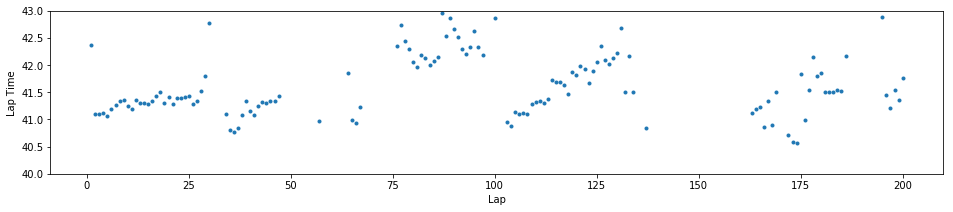

In [18]:
fig, ax = plt.subplots(1,1,figsize=(16,3))
#fig.set_size_inches(15,8)

#ax.set_xlim((0, 33))
ax.set_ylim((40, 43))
ax.set_xlabel('Lap')
ax.set_ylabel('Lap Time')

x = car['completed_laps'][1:].values
y = car['time_diff'][1:].values

#plt.plot(np.arange(laptime.shape[0]), laptime, marker='.')
plt.scatter(x, y, marker='.')

(40, 43)

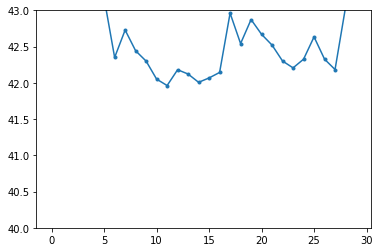

In [8]:
car = cldata[cldata['car_number']==1]
laps = total_laps
laps = 150
laptime = car['time_diff'][70:100]

plt.plot(np.arange(laptime.shape[0]), laptime, marker='.')
plt.ylim(40,43)

In [9]:
outputprefix

'2018-Indy500-'